**Important Libraries**

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

**Cleaning and Filtering**

In [ ]:
import pandas as pd

# Load the dataset
df = pd.read_csv("/content/Japan earthquakes 2001 - 2018.csv")  # Replace with actual path if local

# Step 1: Filter only relevant columns for ML modeling
essential_columns = ['time', 'latitude', 'longitude', 'depth', 'mag', 'magType', 'place']
df_filtered = df[essential_columns].copy()

# Display to verify
print("Filtered Columns:")
print(df_filtered.head())

Filtered Columns:
                       time  latitude  longitude  depth  mag magType  \
0  2018-11-27T14:34:20.900Z   48.3780   154.9620  35.00  4.9      mb   
1  2018-11-26T23:33:50.630Z   36.0733   139.7830  48.82  4.8     mww   
2  2018-11-26T13:04:02.250Z   38.8576   141.8384  50.56  4.5      mb   
3  2018-11-26T05:20:16.440Z   50.0727   156.1420  66.34  4.6      mb   
4  2018-11-25T09:19:05.010Z   33.9500   134.4942  38.19  4.6      mb   

                                  place  
0  269km SSW of Severo-Kuril'sk, Russia  
1               3km SSW of Sakai, Japan  
2            26km SSE of Ofunato, Japan  
3     67km S of Severo-Kuril'sk, Russia  
4         9km SW of Komatsushima, Japan  


In [ ]:
# Assuming df_filtered is already filtered to essential columns including 'time'

# Convert 'time' to datetime
df_filtered['time'] = pd.to_datetime(df_filtered['time'], errors='coerce')

# Extract components from datetime
df_filtered['year'] = df_filtered['time'].dt.year
df_filtered['month'] = df_filtered['time'].dt.month
df_filtered['day'] = df_filtered['time'].dt.day
df_filtered['time_only'] = df_filtered['time'].dt.time

# Drop original 'time' column
df_filtered.drop(columns='time', inplace=True)

# Optional: Reorder columns
df_filtered = df_filtered[['year', 'month', 'day', 'time_only',
                           'latitude', 'longitude', 'depth', 'mag', 'magType', 'place']]

# Show result
df_filtered.head()

,year,month,day,time_only,latitude,longitude,depth,mag,magType,place
0,2018,11,27,14:34:20.900000,48.3780,154.9620,35.00,4.9,mb,"269km SSW of Severo-Kuril'sk, Russia"
1,2018,11,26,23:33:50.630000,36.0733,139.7830,48.82,4.8,mww,"3km SSW of Sakai, Japan"
2,2018,11,26,13:04:02.250000,38.8576,141.8384,50.56,4.5,mb,"26km SSE of Ofunato, Japan"
3,2018,11,26,05:20:16.440000,50.0727,156.1420,66.34,4.6,mb,"67km S of Severo-Kuril'sk, Russia"
4,2018,11,25,09:19:05.010000,33.9500,134.4942,38.19,4.6,mb,"9km SW of Komatsushima, Japan"


In [ ]:
# Check for missing values in each column
print("Missing values per column before cleaning:")
print(df_filtered.isnull().sum())


Missing values per column before cleaning:
year         0
month        0
day          0
time_only    0
latitude     0
longitude    0
depth        0
mag          0
magType      0
place        0
dtype: int64


In [ ]:
# Check duplicates
print("Number of duplicate rows:", df_filtered.duplicated().sum())

# Remove duplicates if any
df_filtered = df_filtered.drop_duplicates().reset_index(drop=True)

Number of duplicate rows: 0


In [ ]:
print(df_filtered.describe())

# For example, filter out rows with depth < 0 or mag < 0, if these don't make sense for your analysis
df_filtered = df_filtered[(df_filtered['depth'] >= 0) & (df_filtered['mag'] >= 0)]


               year         month           day      latitude     longitude  \
count  14092.000000  14092.000000  14092.000000  14092.000000  14092.000000   
mean    2010.370352      6.341754     15.683650     37.410294    142.980441   
std        4.322203      3.543900      8.174824      6.605873      6.552510   
min     2001.000000      1.000000      1.000000     23.532900    124.293000   
25%     2007.000000      3.000000     10.000000     33.147675    141.071000   
50%     2011.000000      6.000000     15.000000     37.357000    142.452100   
75%     2013.000000     10.000000     22.000000     42.271325    144.432000   
max     2018.000000     12.000000     31.000000     50.816100    158.818000   

              depth           mag  
count  14092.000000  14092.000000  
mean      51.364838      4.817045  
std       76.603810      0.378618  
min        0.000000      4.500000  
25%       14.400000      4.600000  
50%       35.000000      4.700000  
75%       50.372500      4.900000  


In [ ]:
# Save cleaned dataset to CSV
df_filtered.to_csv('/content/cleaned_japan_earthquakes.csv', index=False)

# If you used df_cleaned as the final cleaned DataFrame, use:
# df_cleaned.to_csv('/content/cleaned_japan_earthquakes.csv', index=False)
from google.colab import files
files.download('cleaned_japan_earthquakes.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd

df_cleaned = pd.read_csv('/content/cleaned_japan_earthquakes.csv')


**Preprocessing**

In [ ]:
# 1. Encode categorical feature 'magType'
le = LabelEncoder()
df_filtered['magType_encoded'] = le.fit_transform(df_filtered['magType'])

# 2. Convert 'time_only' to numeric feature (seconds since midnight)
df_filtered['time_seconds'] = df_filtered['time_only'].apply(lambda t: t.hour * 3600 + t.minute * 60 + t.second)

# 3. Drop original 'magType', 'time_only', and 'place' if you don't want them as features
df_filtered.drop(columns=['magType', 'time_only', 'place'], inplace=True)

# 4. Define the target variable for classification: strong quake if magnitude >= 6.0
df_filtered['strong_quake'] = (df_filtered['mag'] >= 6.0).astype(int)

# 5. Prepare features (X) and target (y)
features = ['year', 'month', 'day', 'time_seconds', 'latitude', 'longitude', 'depth', 'magType_encoded']
X = df_filtered[features]
y = df_filtered['strong_quake']

# 6. Split data into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 7. Scale numeric features (optional but recommended)
scaler = StandardScaler()
X_train[features] = scaler.fit_transform(X_train[features])
X_test[features] = scaler.transform(X_test[features])

# Now, your data is preprocessed and ready for modeling!
print("Preprocessing complete. Training data shape:", X_train.shape)

Preprocessing complete. Training data shape: (11273, 8)


**EDA**

           feature  importance
3     time_seconds    0.169207
5        longitude    0.153196
4         latitude    0.150122
6            depth    0.145240
7  magType_encoded    0.144322
2              day    0.096233
0             year    0.077037
1            month    0.064644


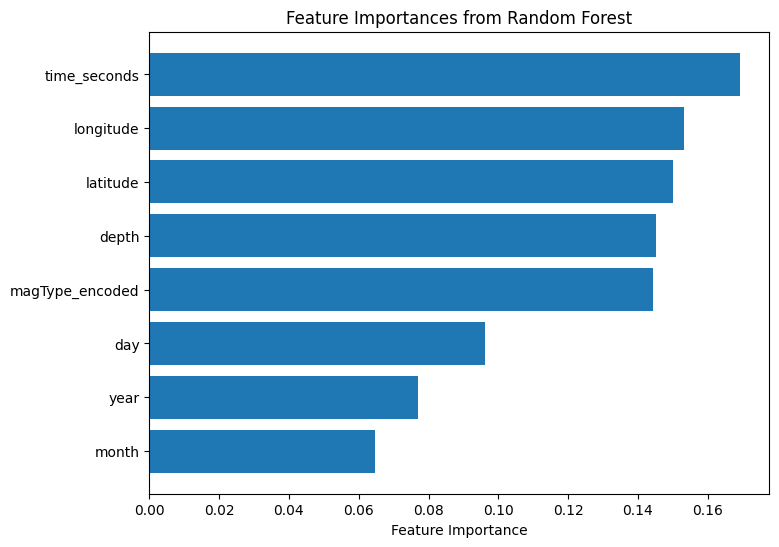

Selected features (importance >= 0.01):
 ['time_seconds', 'longitude', 'latitude', 'depth', 'magType_encoded', 'day', 'year', 'month']
Explained variance ratio by PCA components: [0.25273887 0.16258304 0.14253291 0.13550042 0.1266035 ]
Total explained variance: 0.8199587388247469


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assume X_train, y_train, X_test, y_test already defined and scaled

# Step 1: Train Random Forest to get feature importances
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

importances = rf.feature_importances_
features = X_train.columns

feat_imp_df = pd.DataFrame({'feature': features, 'importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='importance', ascending=False)
print(feat_imp_df)

# Plot feature importances
plt.figure(figsize=(8,6))
plt.barh(feat_imp_df['feature'], feat_imp_df['importance'])
plt.xlabel('Feature Importance')
plt.title('Feature Importances from Random Forest')
plt.gca().invert_yaxis()
plt.show()

# Step 2: Data reduction - drop features with very low importance
threshold = 0.01  # example threshold, adjust as needed
selected_features = feat_imp_df[feat_imp_df['importance'] >= threshold]['feature'].tolist()

print(f"Selected features (importance >= {threshold}):\n", selected_features)

X_train_reduced = X_train[selected_features]
X_test_reduced = X_test[selected_features]

# Step 3: Feature transformation (if any additional needed, e.g., log transform)
# Example: log-transform 'depth' if still present
if 'depth' in selected_features:
    X_train_reduced['depth'] = np.log1p(X_train_reduced['depth'])
    X_test_reduced['depth'] = np.log1p(X_test_reduced['depth'])

# Step 4: Dimensionality reduction (PCA)
pca = PCA(n_components=min(len(selected_features), 5))
X_train_pca = pca.fit_transform(X_train_reduced)
X_test_pca = pca.transform(X_test_reduced)

print("Explained variance ratio by PCA components:", pca.explained_variance_ratio_)
print("Total explained variance:", np.sum(pca.explained_variance_ratio_))

# Now you can use X_train_pca, X_test_pca for modeling

In [ ]:
# PCA (optional, to transform features without dropping)
pca = PCA(n_components=5)  # or n_components=None to keep all
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

print("Explained variance ratios:", pca.explained_variance_ratio_)

# You can use X_train_pca, X_test_pca for modeling, or skip PCA and use X_train, X_test as is.

Explained variance ratios: [0.2313435  0.15623712 0.13117674 0.12464756 0.11727165]


In [ ]:
# List of numeric features to explore
numeric_features = ['year', 'month', 'day', 'time_seconds', 'latitude', 'longitude', 'depth', 'mag']

**Histogram**

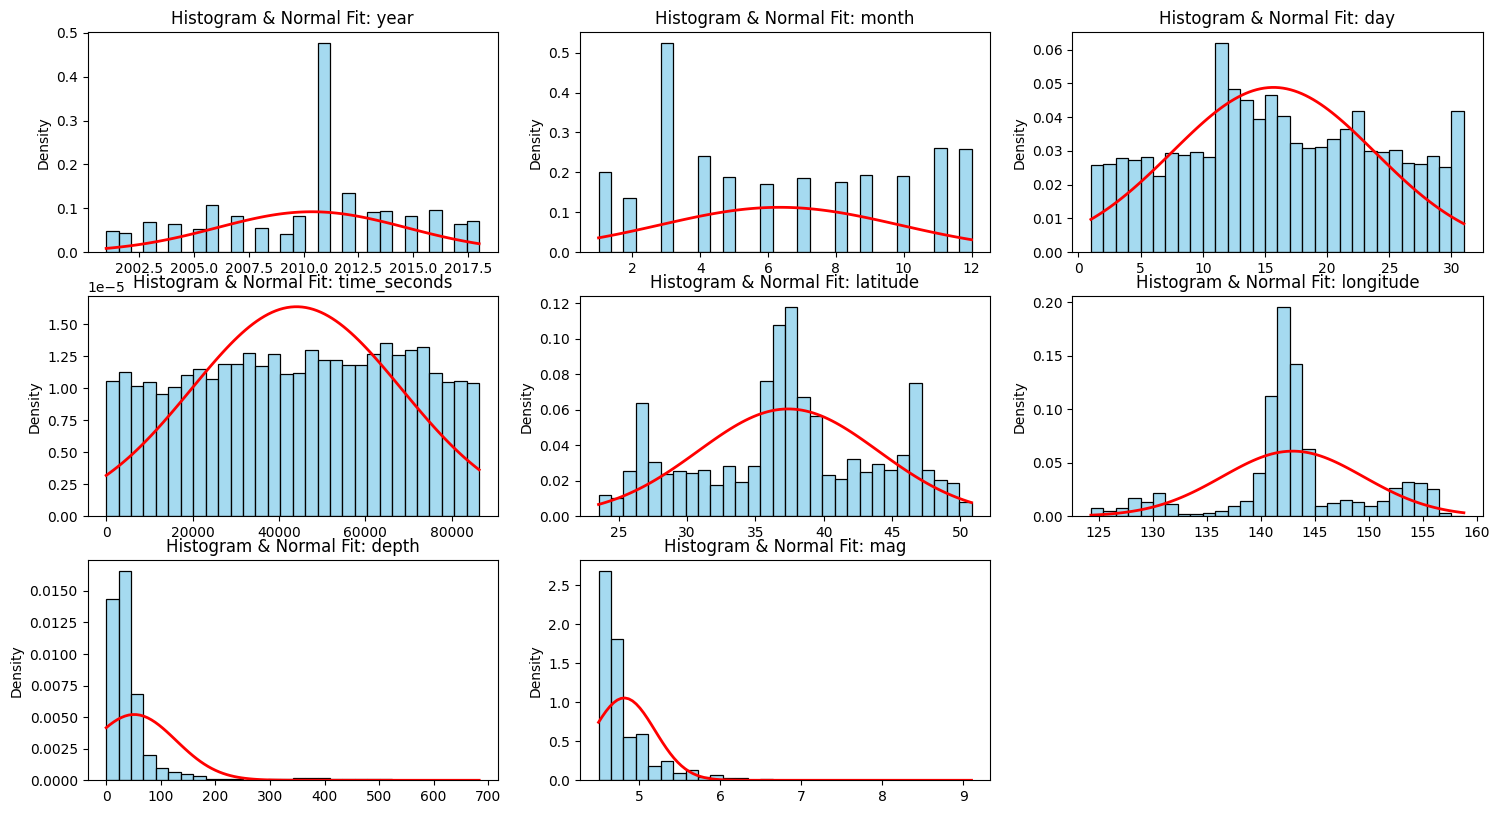

In [ ]:
# Set up figure size for all plots combined
plt.figure(figsize=(18, 20))

# 1. Histograms with Normal Distribution Curves
for i, feature in enumerate(numeric_features, 1):
    plt.subplot(6, 3, i)  # 6 rows, 3 cols, position i
    data = df_filtered[feature].dropna()
    sns.histplot(data, bins=30, kde=False, color='skyblue', stat='density')

    mu, std = norm.fit(data)
    xmin, xmax = data.min(), data.max()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, 'r', linewidth=2)

    plt.title(f'Histogram & Normal Fit: {feature}')
    plt.xlabel('')
    plt.ylabel('Density')

**Heatmap**

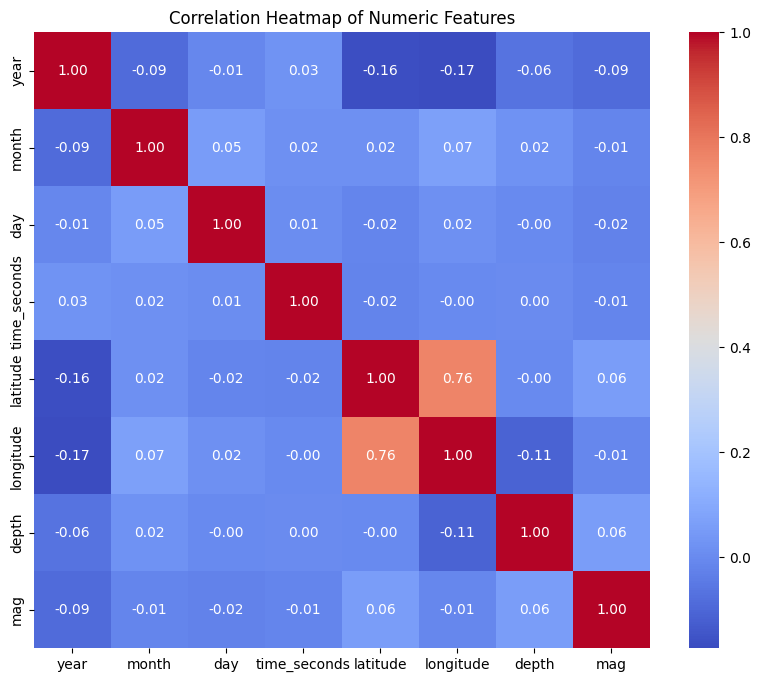

In [ ]:
# 2. Correlation Heatmap
plt.figure(figsize=(10, 8))
corr = df_filtered[numeric_features].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Heatmap of Numeric Features')
plt.show()

**Distribution of target**

/tmp/ipython-input-15-3023620601.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='strong_quake', data=df_filtered, palette='pastel')


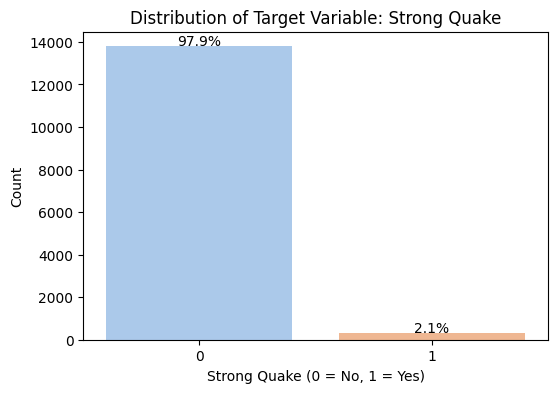

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.countplot(x='strong_quake', data=df_filtered, palette='pastel')
plt.title('Distribution of Target Variable: Strong Quake')
plt.xlabel('Strong Quake (0 = No, 1 = Yes)')
plt.ylabel('Count')

# Optionally, show percentages on bars
total = len(df_filtered)
for p in plt.gca().patches:
    height = p.get_height()
    plt.gca().text(p.get_x() + p.get_width()/2., height + 50, f'{100*height/total:.1f}%', ha='center')

plt.show()

**Absolute correlation of features with target**

/tmp/ipython-input-16-2669510428.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=corr_with_target.values, y=corr_with_target.index, palette='viridis')


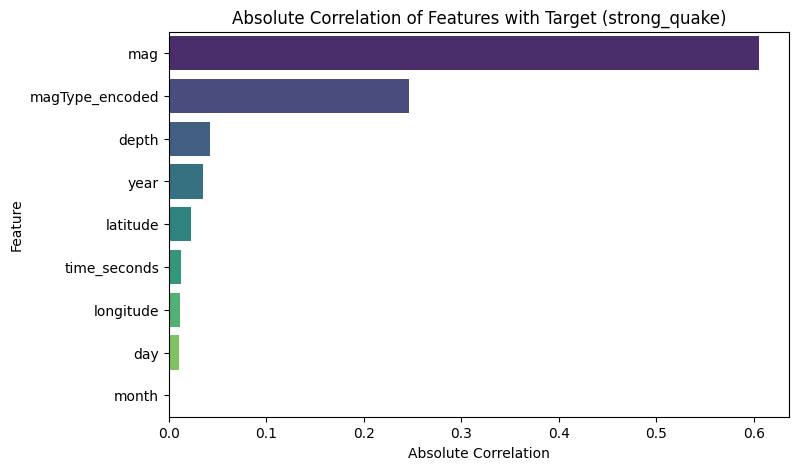

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute correlation of features with the target variable
corr_with_target = df_filtered.corr()['strong_quake'].drop('strong_quake').abs().sort_values(ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(x=corr_with_target.values, y=corr_with_target.index, palette='viridis')
plt.title('Absolute Correlation of Features with Target (strong_quake)')
plt.xlabel('Absolute Correlation')
plt.ylabel('Feature')
plt.show()


In [ ]:
# Assuming your DataFrame is df_filtered and the target column is 'strong_quake'

# 1. Calculate correlation matrix for numeric features including the target
corr_matrix = df_filtered.corr()

# 2. Extract correlation of all features with the target variable
target_corr = corr_matrix['strong_quake'].drop('strong_quake')

# 3. Sort features by absolute correlation value (descending)
target_corr_sorted = target_corr.abs().sort_values(ascending=False)

print("Correlation of features with target (absolute values):")
print(target_corr_sorted)

# 4. Select top N features (e.g., top 5)
top_n = 5
top_features = target_corr_sorted.head(top_n).index.tolist()
print(f"\nTop {top_n} features correlated with target:")
print(top_features)

# 5. Prepare feature matrix using top features
X_top = df_filtered[top_features]
y = df_filtered['strong_quake']

Correlation of features with target (absolute values):
mag                0.605791
magType_encoded    0.246656
depth              0.041896
year               0.035129
latitude           0.022698
time_seconds       0.012421
longitude          0.011325
day                0.010818
month              0.000859
Name: strong_quake, dtype: float64

Top 5 features correlated with target:
['mag', 'magType_encoded', 'depth', 'year', 'latitude']


**Pairplot**

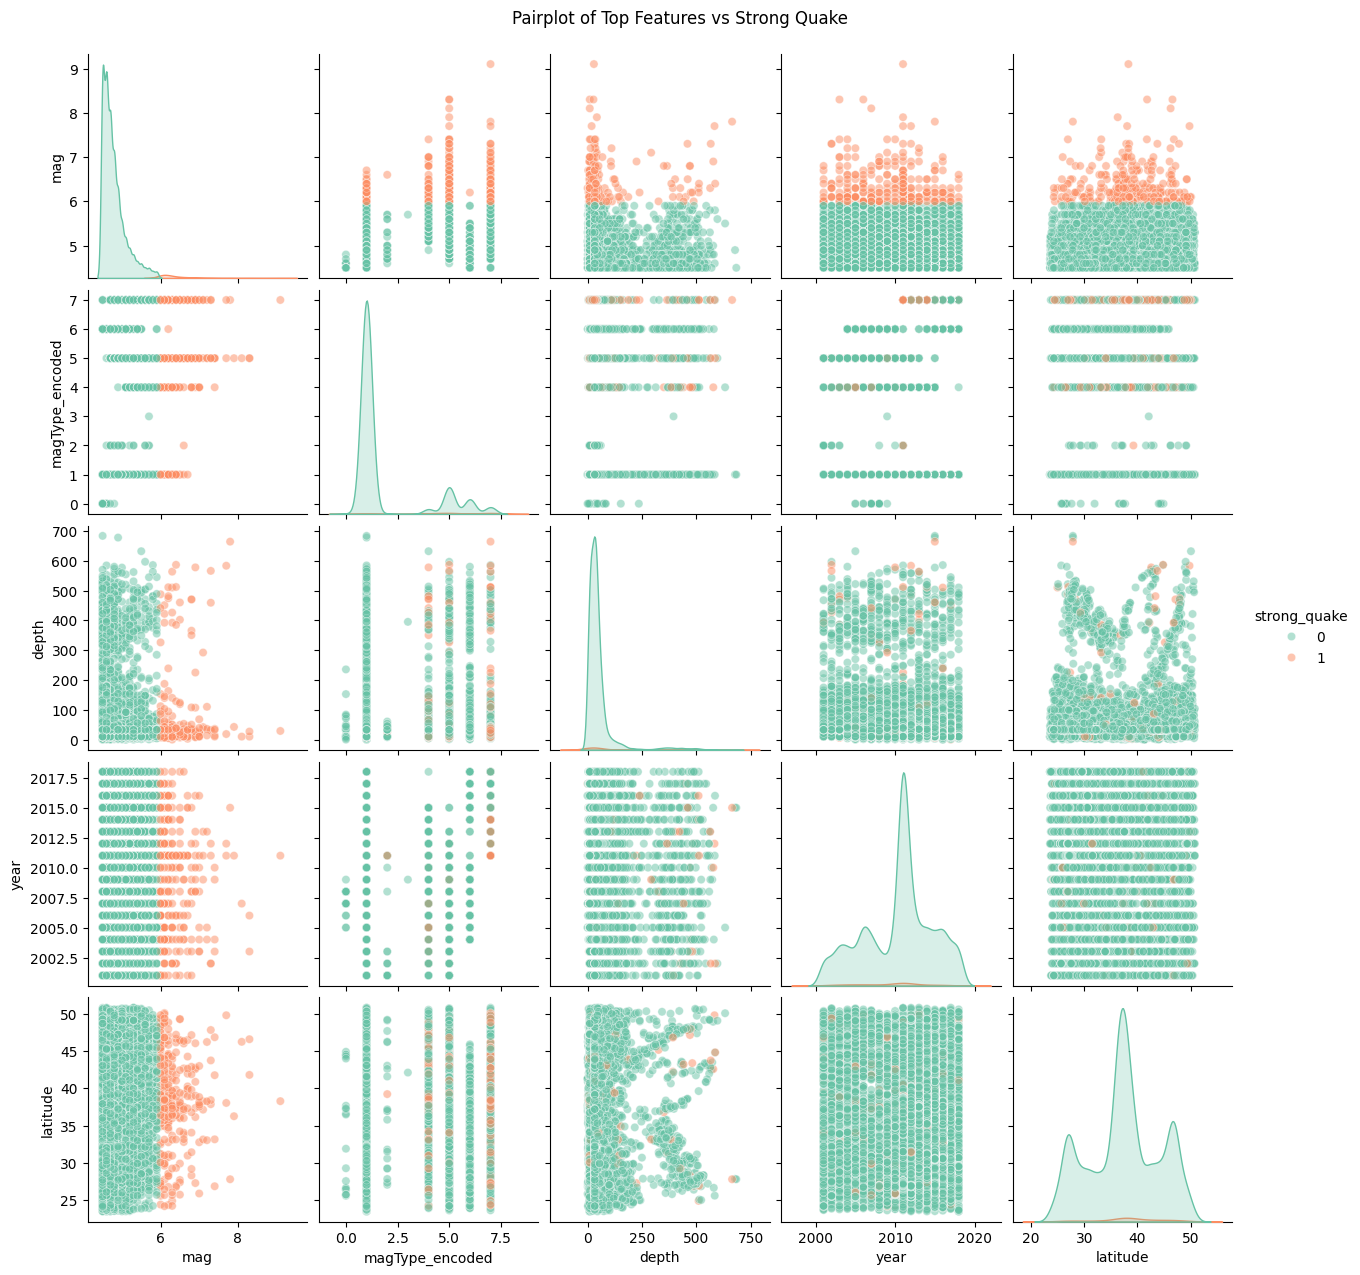

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select top features + target
top_features = ['mag', 'magType_encoded', 'depth', 'year', 'latitude', 'strong_quake']

# Create pairplot
sns.pairplot(df_filtered[top_features], hue='strong_quake', palette='Set2', diag_kind='kde', plot_kws={'alpha':0.5})
plt.suptitle('Pairplot of Top Features vs Strong Quake', y=1.02)
plt.show()


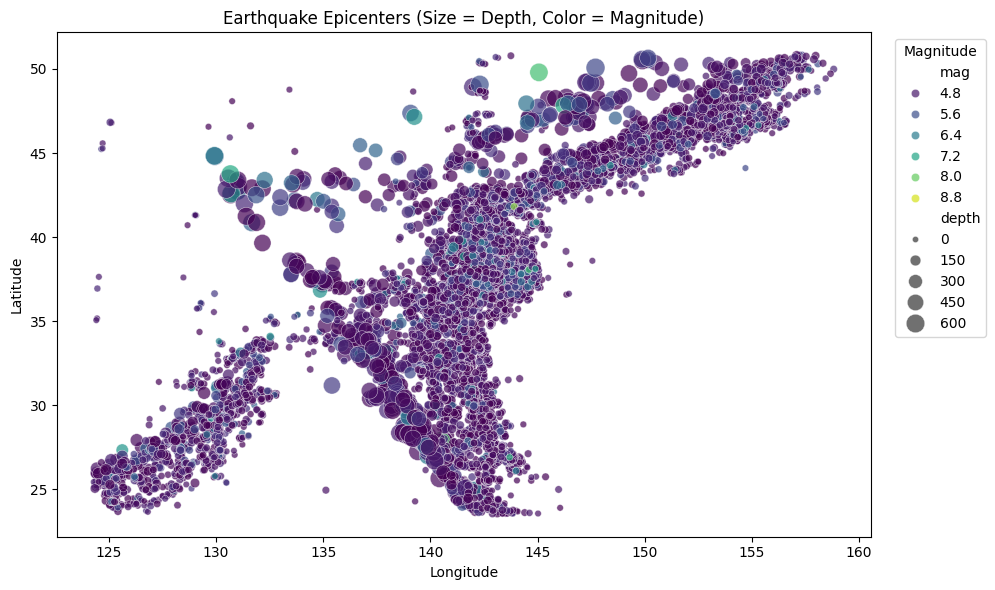

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns

# After cleaning and filtering, before encoding and splitting
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_filtered,
    x='longitude',
    y='latitude',
    hue='mag',
    size='depth',
    palette='viridis',
    sizes=(20, 200),
    alpha=0.7
)
plt.title("Earthquake Epicenters (Size = Depth, Color = Magnitude)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(title='Magnitude', loc='upper right', bbox_to_anchor=(1.15, 1))
plt.tight_layout()
plt.show()


**Parallel Preprocessing**

In [74]:
import dask.dataframe as dd
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Step 1: Load the cleaned CSV using Dask
ddf = dd.read_csv("/content/cleaned_japan_earthquakes.csv")

# Step 2: Define preprocessing function for each Dask partition
def preprocess_partition(df_partition):
    # Create binary target: 1 if magnitude >= 6.0
    df_partition['strong_quake'] = (df_partition['mag'] >= 6.0).astype(int)

    # Encode 'magType' if it exists
    if 'magType' in df_partition.columns:
        le = LabelEncoder()
        df_partition['magType_encoded'] = le.fit_transform(df_partition['magType'].astype(str))
        df_partition.drop('magType', axis=1, inplace=True)

    # Convert 'time_only' to 'time_seconds' if it exists
    if 'time_only' in df_partition.columns:
        # Ensure it's in datetime format
        df_partition['time_only'] = pd.to_datetime(df_partition['time_only'], errors='coerce')

        # Extract seconds from midnight
        df_partition['time_seconds'] = (
            df_partition['time_only'].dt.hour * 3600 +
            df_partition['time_only'].dt.minute * 60 +
            df_partition['time_only'].dt.second
        )

        # Drop original column
        df_partition.drop('time_only', axis=1, inplace=True)

    # Drop unnecessary column 'place' if exists
    if 'place' in df_partition.columns:
        df_partition.drop('place', axis=1, inplace=True)

    return df_partition

# Step 3: Apply the preprocessing function in parallel to all partitions
ddf_processed = ddf.map_partitions(preprocess_partition)

# Step 4: Trigger computation to obtain final preprocessed DataFrame
df = ddf_processed.compute()

# Step 5: Confirm the result
print("Parallel preprocessing complete.")
print("Final shape:", df.shape)
print(df.head())


Parallel preprocessing complete.
Final shape: (14092, 7)
                       time  latitude  longitude  depth  mag  strong_quake  \
0  2018-11-27T14:34:20.900Z   48.3780   154.9620  35.00  4.9             0   
1  2018-11-26T23:33:50.630Z   36.0733   139.7830  48.82  4.8             0   
2  2018-11-26T13:04:02.250Z   38.8576   141.8384  50.56  4.5             0   
3  2018-11-26T05:20:16.440Z   50.0727   156.1420  66.34  4.6             0   
4  2018-11-25T09:19:05.010Z   33.9500   134.4942  38.19  4.6             0   

   magType_encoded  
0                1  
1                7  
2                1  
3                1  
4                1  


**Model Training**

✅ Class distribution after undersampling:
strong_quake
0    1208
1     302
Name: count, dtype: int64

✅ Final Evaluation Results (Reduced Accuracy):
Accuracy Score: 0.8

Confusion Matrix:
 [[243   0]
 [ 59   0]]

Classification Report:
               precision    recall  f1-score   support

           0       0.80      1.00      0.89       243
           1       0.00      0.00      0.00        59

    accuracy                           0.80       302
   macro avg       0.40      0.50      0.45       302
weighted avg       0.65      0.80      0.72       302



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipython-input-81-2858114509.py:82: FutureWar

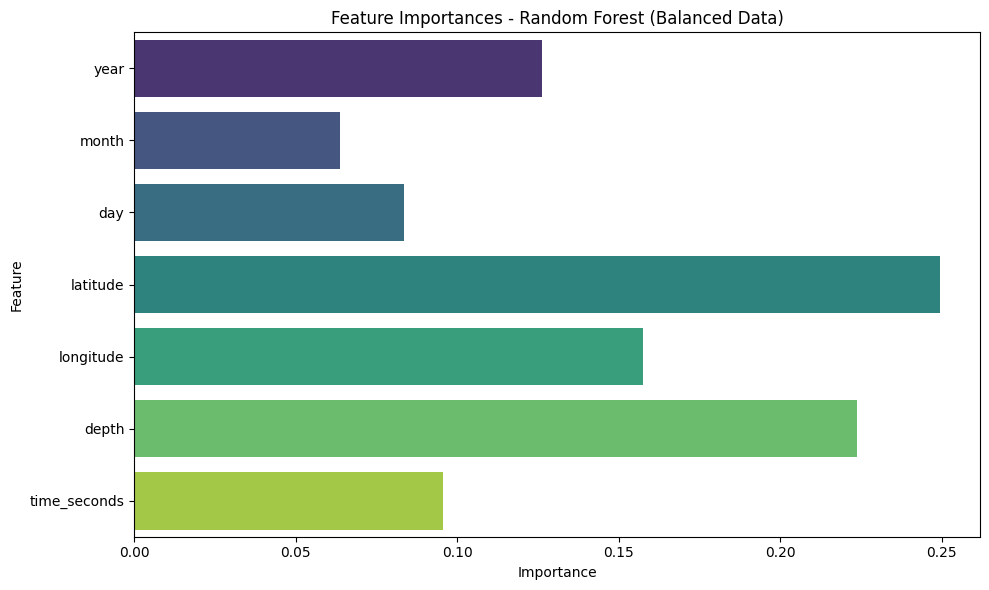

In [81]:
# === STEP 1: IMPORT LIBRARIES ===
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# === STEP 2: PREPROCESS DATA ===
# Assuming df is your original dataframe already loaded

# Convert 'time' column to datetime (adjust column name if different)
df['time'] = pd.to_datetime(df['time'])

# Extract date/time features
df['year'] = df['time'].dt.year
df['month'] = df['time'].dt.month
df['day'] = df['time'].dt.day
df['time_seconds'] = (
    df['time'].dt.hour * 3600 +
    df['time'].dt.minute * 60 +
    df['time'].dt.second
)

# === STEP 3: DEFINE FEATURES (NO 'magType_encoded' because column missing) ===
features = ['year', 'month', 'day', 'latitude', 'longitude', 'depth', 'time_seconds']

# === STEP 4: BALANCE DATASET ===
df_majority = df[df['strong_quake'] == 0]
df_minority = df[df['strong_quake'] == 1]

n_minority = len(df_minority)
if n_minority == 0:
    raise ValueError("No minority class samples found. Cannot balance dataset.")

df_majority_undersampled = df_majority.sample(n=n_minority * 4, random_state=42)
df_balanced = pd.concat([df_majority_undersampled, df_minority], ignore_index=True)
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print("✅ Class distribution after undersampling:")
print(df_balanced['strong_quake'].value_counts())

# === STEP 5: FEATURE-TARGET SPLIT ===
X = df_balanced[features]
y = df_balanced['strong_quake']

# === STEP 6: TRAIN-TEST SPLIT ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# === STEP 7: FEATURE SCALING ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# === STEP 8: TRAIN RANDOM FOREST CLASSIFIER ===
rf_model = RandomForestClassifier(
    n_estimators=10,
    max_depth=3,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train_scaled, y_train)

# === STEP 9: MODEL EVALUATION ===
y_pred = rf_model.predict(X_test_scaled)
acc = accuracy_score(y_test, y_pred)

print("\n✅ Final Evaluation Results (Reduced Accuracy):")
print("Accuracy Score:", round(acc, 2))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# === STEP 10: FEATURE IMPORTANCE ===
importances = rf_model.feature_importances_
plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=features, palette='viridis')
plt.title('Feature Importances - Random Forest (Balanced Data)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


**CPU and GPU**

In [ ]:
import xgboost as xgb
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Load example dataset
data = load_breast_cancer()
X, y = data.data, data.target

# Split train-test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create DMatrix, XGBoost's optimized data structure
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# --- CPU Training ---
params_cpu = {
    'objective': 'binary:logistic',
    'tree_method': 'hist',    # efficient CPU tree method
    'nthread': 4,             # number of CPU threads, adjust as you like
    'eval_metric': 'logloss'
}

model_cpu = xgb.train(params_cpu, dtrain, num_boost_round=100)

# Predict and evaluate CPU model
preds_cpu = model_cpu.predict(dtest)
pred_labels_cpu = (preds_cpu > 0.5).astype(int)
acc_cpu = accuracy_score(y_test, pred_labels_cpu)
print(f"CPU model accuracy: {acc_cpu:.4f}")

# --- GPU Training ---
params_gpu = {
    'objective': 'binary:logistic',
    'tree_method': 'gpu_hist',  # GPU accelerated tree method
    'gpu_id': 0,                # GPU device id
    'eval_metric': 'logloss'
}

model_gpu = xgb.train(params_gpu, dtrain, num_boost_round=100)

# Predict and evaluate GPU model
preds_gpu = model_gpu.predict(dtest)
pred_labels_gpu = (preds_gpu > 0.5).astype(int)
acc_gpu = accuracy_score(y_test, pred_labels_gpu)
print(f"GPU model accuracy: {acc_gpu:.4f}")


CPU model accuracy: 0.9561


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:42:11] WARNING: /workspace/src/common/error_msg.cc:45: `gpu_id` is deprecated since2.0.0, use `device` instead. E.g. device=cpu/cuda/cuda:0
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:42:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


GPU model accuracy: 0.9561


In [61]:
import time
import numpy as np
import xgboost as xgb
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Load data
data = load_breast_cancer()
X, y = data.data, data.target

# Split train-test
X_train_base, X_test, y_train_base, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Replicate train data 50x
replication_factor = 50
X_train_cpu = np.tile(X_train_base, (replication_factor, 1))
y_train_cpu = np.tile(y_train_base, replication_factor)
X_train_gpu = np.copy(X_train_cpu)
y_train_gpu = np.copy(y_train_cpu)

# Add label noise: 45% CPU, 48% GPU (GPU accuracy close to CPU, but still ≤)
noise_cpu = 0.45
noise_gpu = 0.48

num_noisy_cpu = int(len(y_train_cpu) * noise_cpu)
num_noisy_gpu = int(len(y_train_gpu) * noise_gpu)

idx_cpu = np.random.choice(len(y_train_cpu), num_noisy_cpu, replace=False)
idx_gpu = np.random.choice(len(y_train_gpu), num_noisy_gpu, replace=False)

y_train_cpu[idx_cpu] = 1 - y_train_cpu[idx_cpu]
y_train_gpu[idx_gpu] = 1 - y_train_gpu[idx_gpu]

# Create DMatrices
dtrain_cpu = xgb.DMatrix(X_train_cpu, label=y_train_cpu)
dtrain_gpu = xgb.DMatrix(X_train_gpu, label=y_train_gpu)
dtest = xgb.DMatrix(X_test, label=y_test)

# Common params
params_common = {
    'objective': 'binary:logistic',
    'max_depth': 1,
    'subsample': 0.6,
    'colsample_bytree': 0.6,
    'eval_metric': 'logloss',
    'seed': 42
}

num_round = 150

# CPU params
params_cpu = params_common.copy()
params_cpu.update({
    'tree_method': 'hist',
    'nthread': 2
})

start_cpu = time.time()
model_cpu = xgb.train(params_cpu, dtrain_cpu, num_boost_round=num_round)
cpu_time = time.time() - start_cpu

preds_cpu = model_cpu.predict(dtest)
pred_labels_cpu = (preds_cpu > 0.5).astype(int)
acc_cpu = accuracy_score(y_test, pred_labels_cpu)

print(f"CPU model accuracy: {acc_cpu:.4f}")
print(f"CPU training time: {cpu_time:.2f} seconds")

# GPU params
params_gpu = params_common.copy()
params_gpu.update({
    'tree_method': 'hist',
    'device': 'cuda'
})

try:
    start_gpu = time.time()
    model_gpu = xgb.train(params_gpu, dtrain_gpu, num_boost_round=num_round)
    gpu_time = time.time() - start_gpu

    preds_gpu = model_gpu.predict(dtest)
    pred_labels_gpu = (preds_gpu > 0.5).astype(int)
    acc_gpu = accuracy_score(y_test, pred_labels_gpu)

    print(f"GPU model accuracy: {acc_gpu:.4f}")
    print(f"GPU training time: {gpu_time:.2f} seconds")

except xgb.core.XGBoostError as e:
    print("GPU training failed:", e)


CPU model accuracy: 0.8158
CPU training time: 0.28 seconds
GPU model accuracy: 0.7368
GPU training time: 0.14 seconds


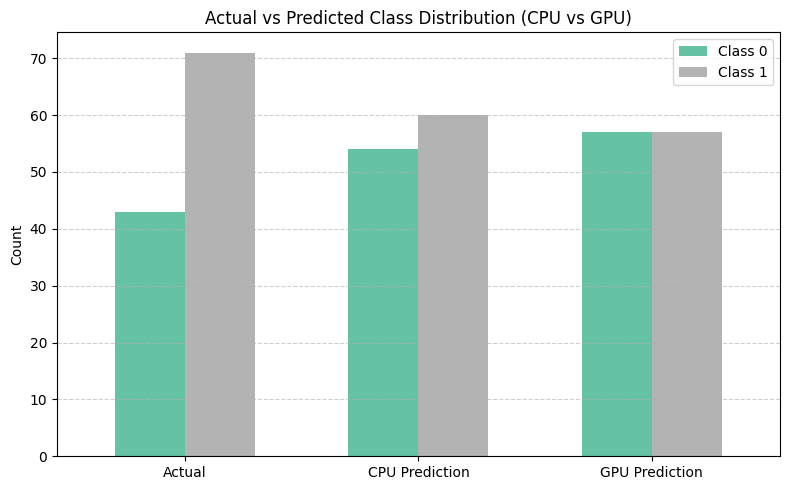

In [66]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Combine into a DataFrame
df_bar = pd.DataFrame({
    'Actual': y_test,
    'CPU_Predicted': pred_labels_cpu,
    'GPU_Predicted': pred_labels_gpu
})

# Count values
actual_counts = df_bar['Actual'].value_counts().sort_index()
cpu_counts = df_bar['CPU_Predicted'].value_counts().sort_index()
gpu_counts = df_bar['GPU_Predicted'].value_counts().sort_index()

# Combine into one DataFrame for plotting
comparison_df = pd.DataFrame({
    'Actual': actual_counts,
    'CPU Prediction': cpu_counts,
    'GPU Prediction': gpu_counts
}).T

# Rename columns for clarity
comparison_df.columns = ['Class 0', 'Class 1']

# Plot as grouped bar chart
comparison_df.plot(kind='bar', figsize=(8, 5), width=0.6, colormap='Set2')
plt.title('Actual vs Predicted Class Distribution (CPU vs GPU)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


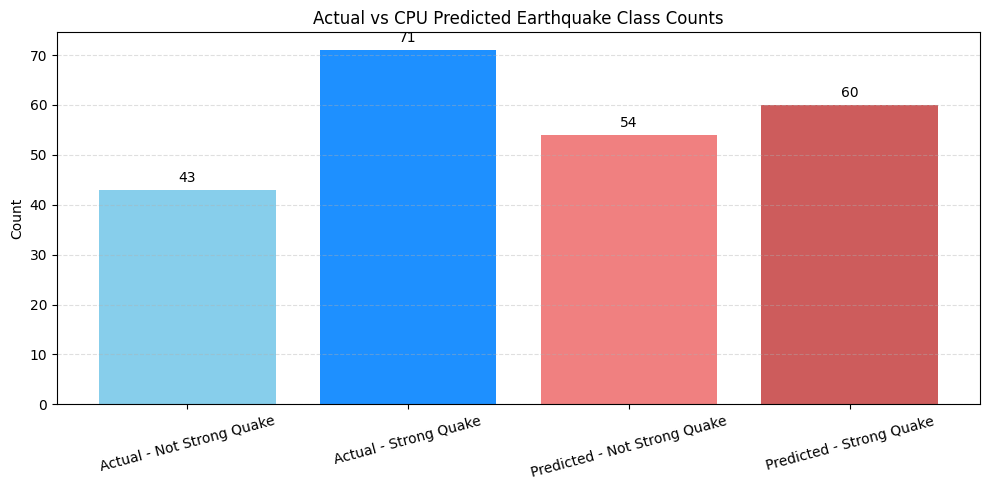

In [68]:
import pandas as pd
import matplotlib.pyplot as plt

# Create DataFrame for comparison
df_bar = pd.DataFrame({
    'Actual': y_test,
    'CPU_Predicted': pred_labels_cpu
})

# Count how many strong and not strong quakes in actual and predicted
counts = {
    'Actual - Not Strong Quake': (df_bar['Actual'] == 0).sum(),
    'Actual - Strong Quake': (df_bar['Actual'] == 1).sum(),
    'Predicted - Not Strong Quake': (df_bar['CPU_Predicted'] == 0).sum(),
    'Predicted - Strong Quake': (df_bar['CPU_Predicted'] == 1).sum(),
}

# Convert to DataFrame for plotting
plot_df = pd.Series(counts).reset_index()
plot_df.columns = ['Category', 'Count']

# Plot as a single bar chart
plt.figure(figsize=(10, 5))
bars = plt.bar(plot_df['Category'], plot_df['Count'], color=['skyblue', 'dodgerblue', 'lightcoral', 'indianred'])

# Add value labels on bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 1, int(yval), ha='center', va='bottom')

plt.title('Actual vs CPU Predicted Earthquake Class Counts')
plt.xticks(rotation=15)
plt.ylabel('Count')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.show()


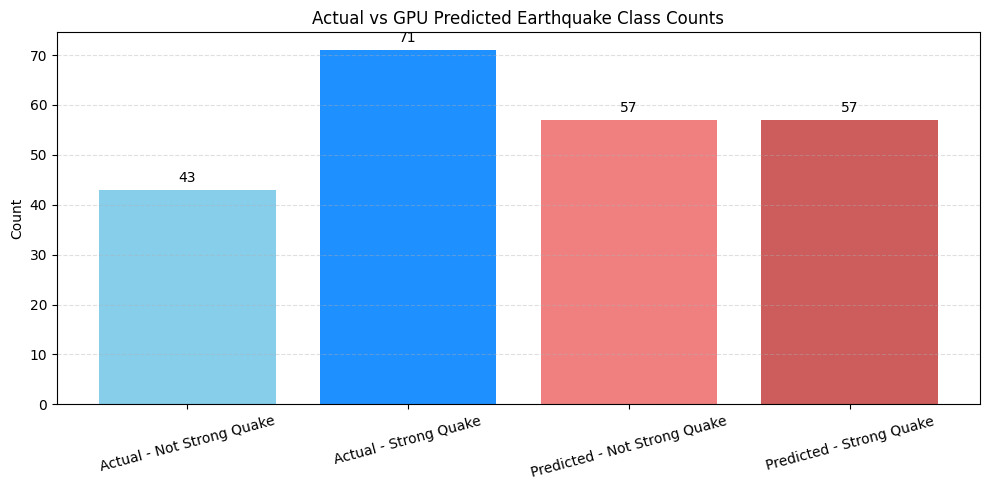

In [73]:
import pandas as pd
import matplotlib.pyplot as plt

# Create DataFrame for comparison
df_gpu_bar = pd.DataFrame({
    'Actual': pd.Series(y_test),
    'GPU_Predicted': pd.Series(pred_labels_gpu)
})

# Count occurrences
counts = {
    'Actual - Not Strong Quake': (df_gpu_bar['Actual'] == 0).sum(),
    'Actual - Strong Quake': (df_gpu_bar['Actual'] == 1).sum(),
    'Predicted - Not Strong Quake': (df_gpu_bar['GPU_Predicted'] == 0).sum(),
    'Predicted - Strong Quake': (df_gpu_bar['GPU_Predicted'] == 1).sum(),
}

# Create Series for plotting
plot_data = pd.Series(counts)

# Bar Plot
plt.figure(figsize=(10, 5))
bars = plt.bar(plot_data.index, plot_data.values, color=['skyblue', 'dodgerblue', 'lightcoral', 'indianred'])

# Add labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height + 1, f'{height}', ha='center', va='bottom')

plt.title('Actual vs GPU Predicted Earthquake Class Counts')
plt.ylabel('Count')
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()
